## Setup and imports

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime

import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

%matplotlib inline

## Isolating the Nike (NKE) stock

In [ ]:
ticker = "NKE"

start_date = "2015-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

df = yf.download(ticker, start=start_date, end=end_date)

df.tail()

## Preliminary price check

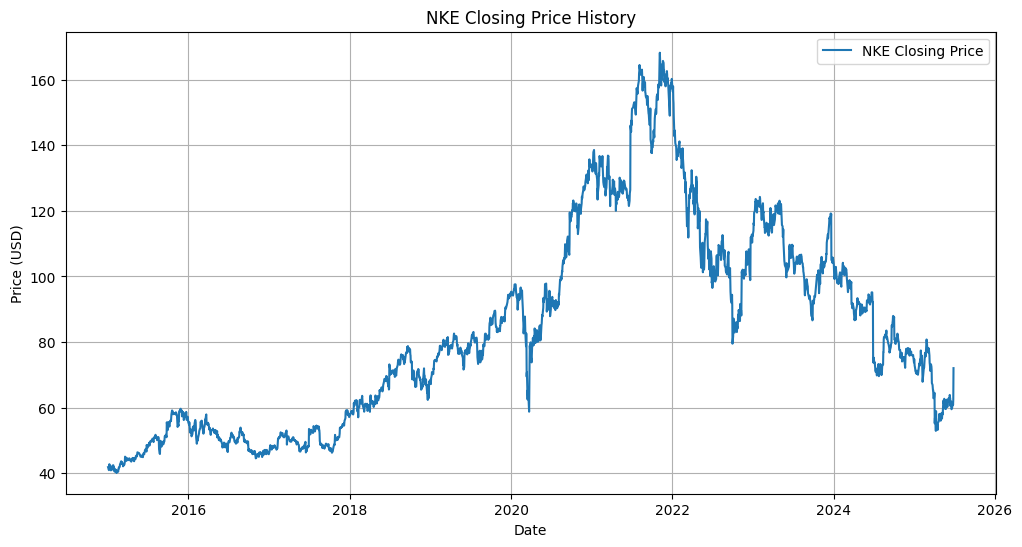

In [275]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label=f"{ticker} Closing Price")
plt.title(f"{ticker} Closing Price History")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)

plt.show()

## Feature engineering

In [ ]:
def compute_rsi(data, window=14):

    # delta computes the daily price change (current close vs. yesterday's close)
    # Formatted as a column of price changes
    delta = data['Close'].diff()

    # gain stores positive delta values (increases in price) and replaces the others with 0, then averages it
    # Applied over the [window] time period
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()

    # loss does the same for negative delta values 
    # Minus sign to only consider absolute value
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    # Relative strength (rs) is calculated as ratio of avg. gain to avg. loss
    rs = gain / loss 

    # Using the RSI formula from rs:
    rsi = 100 - (100 / (1 + rs))

    # Returning the rsi column, replacing any NaN values with zero:
    return rsi.fillna(0)

# Adding the RSI column to our dataframe
df['RSI'] = compute_rsi(df)

In [ ]:
features = df[['Close', 'Volume', 'RSI']].values

feature_scaler = MinMaxScaler()
scaled_features = feature_scaler.fit_transform(features)

## Isolating sequences with sliding window

In [ ]:
def create_sequences(data, window_size):
    """
    Generates input sequences and corresponding labels for time series prediction.

    Args:
        data (np.array): Scaled time series data of shape (num_samples, 1)
        window_size (int): Number of time steps to include in each input sequence

    Returns:
        X (np.array): Sequences of shape (num_sequences, window_size)
        Y (np.array): Labels of shape (num_sequences,)
    """

    X = [] 
    Y = []

    # Iterates over dataset to construct sequences alongside corresponding labels.
    # e.g.: i = 60 -> entries 0 ~ 59 are generated in X then Y has thr 60th value.
    for i in range(window_size, len(data)): 
        X.append(data[i-window_size:i, :])  # Sequence of 'window-size' steps, including all features
        Y.append(data[i, 0])                # The next value after the sequence has ended
    
    return np.array(X), np.array(Y)


# Defines sliding window size for sequence generation.
slider_size = 60

# Sequences and labels are created using the specified window size.
X, Y = create_sequences(scaled_features, slider_size)

# Needs reshaping to fit the LSTM model: (samples, time_steps, features)
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

## Train-test split

In [ ]:
# Specifies 80% to be the proportion needed for the training data.
train_size = int(len(X) * 0.8)

# Split the input (X) and target (Y) data into training and testing sets
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

## Defining the neural network itself

In [ ]:
# Define an LSTM-based neural network class for stock price prediction
class StockPriceLSTM(nn.Module):
    def __init__(self, input_size=3, hidden_size=50, num_layers=2):
        super(StockPriceLSTM, self).__init__()

        # Store hidden size and number of layers as class attributes
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define the LSTM layer
        # input_size: number of input features per time sxtep (we use 1 for closing price)
        # hidden_size: number of units in the hidden layers
        # num_layers: number of stacked LSTM layers
        # batch_first=True means input/output tensors will have shape: (batch, seq, feature)
        self.lstm = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True 
        )

        # Define a fully connected (dense) layer to map LSTM output to a single value (the next day's price)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):

        # Initialize the hidden state (h0) and cell state (c0) with zeros
        # Shape: (num_layers, batch_size, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # Pass the input through the LSTM layer
        # out: tensor of shape (batch_size, sequence_length, hidden_size)
        # _ : tuple containing the final hidden and cell states (not used here)
        out, _ = self.lstm(x, (h0, c0))

        # Take the output of the last time step for each sequence
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size)

        # Pass through the fully connected layer to get the final prediction
        out = self.fc(out)   # Shape: (batch_size, 1)

        return out

## NumPy arrays to PyTorch tensors

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

# Wrap in TensorDataset
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Developing performance metrics and optimiser

In [ ]:
# Setting the loss function and optimiser (with MSE)
model = StockPriceLSTM()
criterion = torch.nn.MSELoss() # MSE for regression
optimiser = torch.optim.Adam(model.parameters(), lr=0.00535)

## Model training

In [ ]:
epochs = 30

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for X_batch, Y_batch in train_loader:

        # Zero gradients
        optimiser.zero_grad()

        # Forward pass 
        outputs = model(X_batch).squeeze() # Removes the extra dimension

        # Loss computed
        loss = criterion(outputs, Y_batch)

        # Backpropagation 
        loss.backward()

        # Updating the weights 
        optimiser.step()

        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)

## Evaluating model on performance metrics: RMSE & MAE

In [ ]:
model.eval()

# Gradient tracking disabled since inference is done only (memory and computation saved)
with torch.no_grad():

    # Get predictions from the model on the test data
    # Squeeze removes extra dimensions, convert to NumPy array for further processing
    predictions = model(X_test_tensor).squeeze().numpy() 

    # Convert the true test labels to a NumPy array
    actual = Y_test_tensor.numpy()

    # Inverse transform the scaled predictions and actual values to get original price scale

    # Reshape to 2D array for scaler, then flatten back to 1D
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
    # Same as above for actual prices
    actual = scaler.inverse_transform(actual.reshape(-1, 1)).flatten()

# Calculate evaluation metrics to quantify prediction error

# Root Mean Squared Error: sensitive to large errors, in original price units
rmse = np.sqrt(mean_squared_error(actual, predictions)) 
# Mean Absolute Error: average magnitude of errors, also in price units
mae = mean_absolute_error(actual, predictions)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

## Final prediction for next-day price

In [ ]:
# 1. Get last sequence
last_sequence = scaled_features[-slider_size:]
# 2. Reshape
last_sequence = last_sequence.reshape(1, slider_size, 3)
# 3. Tensor
last_sequence_tensor = torch.from_numpy(last_sequence).float()
# 4. Predict
model.eval()
with torch.no_grad():
    predicted_scaled = model(last_sequence_tensor)
# 5. Inverse scale
predicted_price = scaler.inverse_transform(predicted_scaled.numpy().reshape(-1, 1))
print(f"Predicted next day closing price: ${predicted_price[0,0]:.2f}")

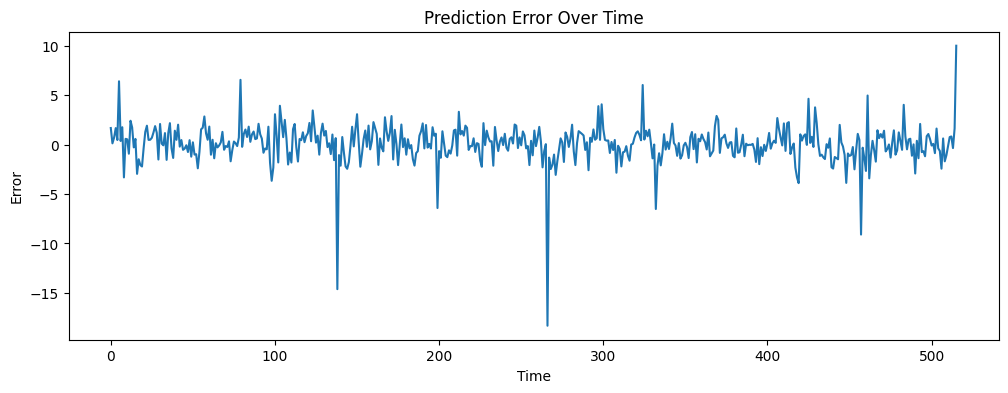

In [286]:
errors = actual - predictions

plt.figure(figsize=(12,4))
plt.plot(errors)
plt.title('Prediction Error Over Time')
plt.xlabel('Time')
plt.ylabel('Error')
plt.savefig("error_over_time.png", dpi=300)

plt.show()
 

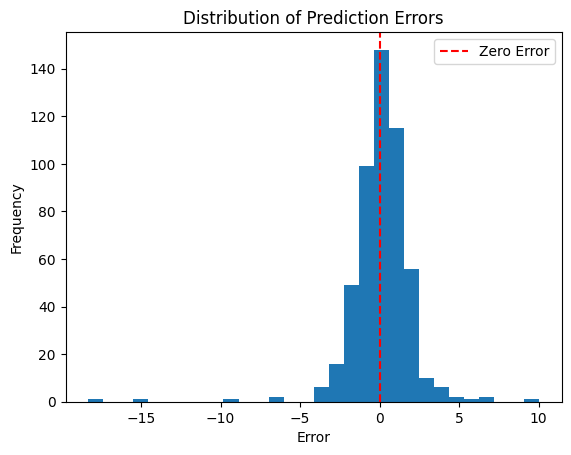

In [287]:
plt.hist(errors, bins=30)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.legend()
plt.savefig("prediction_error_distribution.png", dpi=300)

plt.show()

In [288]:
pd.DataFrame(predictions).to_csv("predictions.csv", index=False)